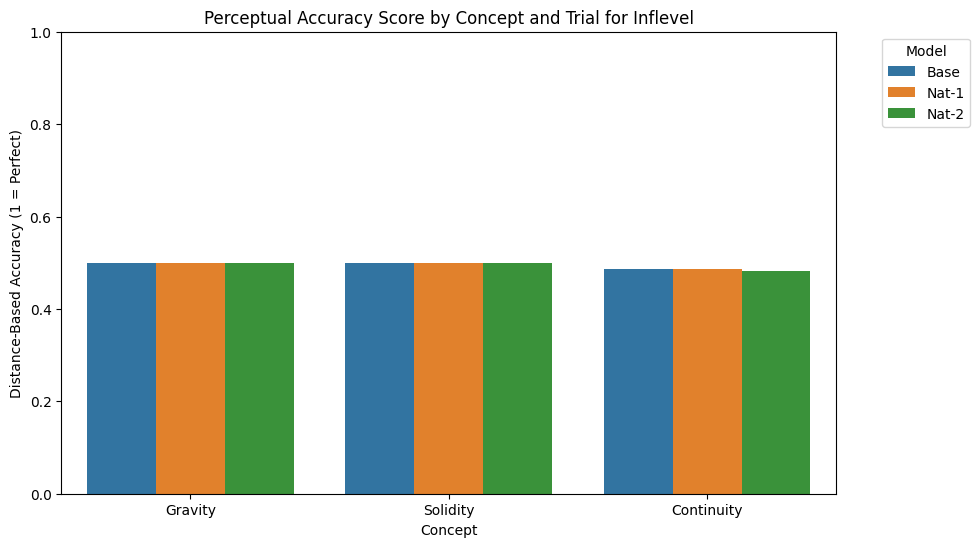

In [27]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def extract_concept(video_name):
    return video_name.split('__')[1].lower()

def get_expected_response(row):
    concept = extract_concept(row['video_name'])
    trial_type = row['trial_type'].lower()

    if concept == 'gravity':
        return 10 if trial_type in ['ui', 'cv'] else 1
    elif concept == 'solidity':
        return 10 if trial_type in ['ui', 'cv'] else 1
    elif concept == 'continuity':
        return 10 if trial_type in ['vv', 'ii'] else 1
    else:
        return 5  # Default midpoint fallback

# Calculate scaled distance score per row
def compute_distance_score(df):
    df['expected'] = df.apply(get_expected_response, axis=1)
    df['score'] = 1 - (abs(df['response_value'] - df['expected']) / 9)
    return df['score'].mean()

# General function for comparing 3 CSVs per concept
def compare_concept_trials(concept_name, filepaths):
    scores = []
    trial_labels = ['Base', 'Nat-1', 'Nat-2']  # Custom labels in the desired order
    
    for i, path in enumerate(filepaths):
        df = pd.read_csv(path)
        avg_score = compute_distance_score(df)
        scores.append((concept_name.capitalize(), trial_labels[i], avg_score))
    
    return scores


# Main visualization function
def plot_overall_comparison(all_scores):
    df_plot = pd.DataFrame(all_scores, columns=['Concept', 'Trial', 'Score'])
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='Concept', y='Score', hue='Trial')
    plt.ylim(0, 1)
    plt.title("Perceptual Accuracy Score by Concept and Trial for Inflevel")
    plt.ylabel("Distance-Based Accuracy (1 = Perfect)")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside
    plt.show()

# 🔽 Sample usage:
gravity_csvs = ['video_responses_gravity-natbase.csv', 'video_responses_gravity-natv2.csv', 'video_responses_gravity-natv2.csv']
solidity_csvs = ['video_responses_solidity-natbase.csv', 'video_responses_solidity-natv1.csv', 'video_responses_solidity-natv2.csv']
continuity_csvs = ['video_responses_continuity-natbase.csv', 'video_responses_continuity-natv1.csv', 'video_responses_continuity-natv2.csv']

all_scores = []
all_scores.extend(compare_concept_trials("gravity", gravity_csvs))
all_scores.extend(compare_concept_trials("solidity", solidity_csvs))
all_scores.extend(compare_concept_trials("continuity", continuity_csvs))

plot_overall_comparison(all_scores)

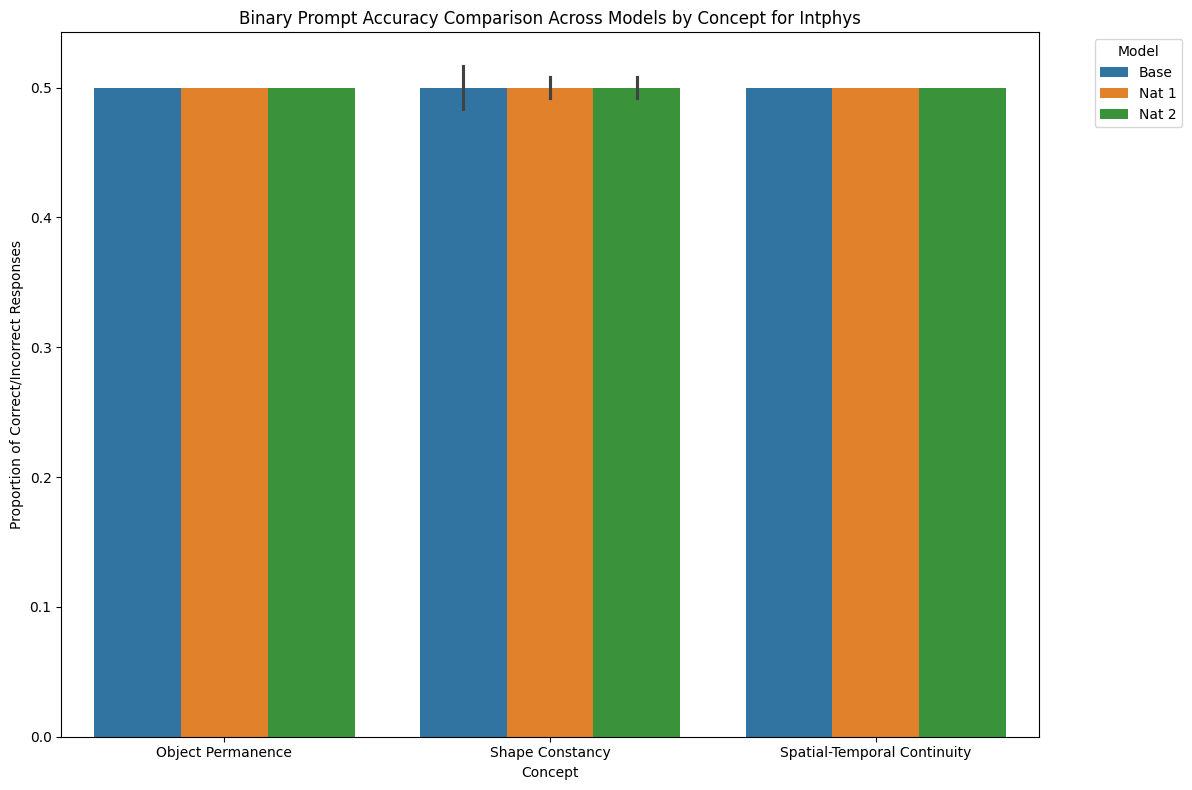

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to prepare binary data
def prepare_binary_data(filepaths):
    # Concept labels corresponding to filepaths
    concept_labels = ['Object Permanence', 'Shape Constancy', 'Spatial-Temporal Continuity']
    trial_labels = ['Base', 'Nat 1', 'Nat 2']
    
    all_scores = []

    # Flatten the list of filepaths before processing
    filepaths = [filepath for sublist in filepaths for filepath in sublist]  # Flatten list of lists
    
    # Load and process each file (3 files per concept)
    for i, concept_label in enumerate(concept_labels):
        for j, path in enumerate(filepaths[i*3:(i+1)*3]):  # Get three files per concept
            df = pd.read_csv(path)
            
            # Map 'Yes' to True and 'No' to False for the response column
            df['response'] = df['response'].map({'Yes': True, 'No': False})
            
            # Calculate the accuracy by comparing 'response' to 'label'
            df['accuracy'] = df['response'] == df['label']
            
            # Add Concept and Trial labels
            df['Concept'] = concept_label
            df['Trial'] = trial_labels[j]
            
            all_scores.append(df)

    return pd.concat(all_scores, ignore_index=True)

# Main function to plot the comparison
def plot_accuracy_comparison(all_scores):
    # Create the plot
    plt.figure(figsize=(12, 8))

    # Compute proportions of correct/incorrect for each Concept, Trial, and Accuracy
    accuracy_data = all_scores.groupby(['Concept', 'Trial', 'accuracy']).size().reset_index(name='count')
    
    # Calculate the total count for each (Concept, Trial)
    total_counts = accuracy_data.groupby(['Concept', 'Trial'])['count'].transform('sum')
    
    # Calculate the proportion of correct (accuracy=True) vs incorrect (accuracy=False)
    accuracy_data['proportion'] = accuracy_data['count'] / total_counts


    # Create the plot (side-by-side bars for each Model)
    sns.barplot(data=accuracy_data, x='Concept', y='proportion', hue='Trial')

    # Adjust plot labels and title
    plt.title("Binary Prompt Accuracy Comparison Across Models by Concept for Intphys")
    plt.ylabel("Proportion of Correct/Incorrect Responses")
    plt.xlabel("Concept")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside

    plt.tight_layout()  # Ensure everything fits
    plt.show()

# 🔽 Sample usage:
object_permanence_csvs = ['resp_intphys_O1_binary_base.csv', 'resp_intphys_O1_binary_nat.csv', 'resp_intphys_O1_binary_nat-2000.csv']
shape_constancy_csvs = ['resp_intphys_O2_binary_base.csv', 'resp_intphys_O2_binary_nat.csv', 'resp_intphys_O2_binary_nat-2000.csv']
spatial_temporal_continuity_csvs = ['resp_intphys_O3_binary_base.csv', 'resp_intphys_O3_binary_nat.csv', 'resp_intphys_O3_binary_nat-2000.csv']

# Collect all the binary data from each concept (3 CSVs per concept)
all_scores = prepare_binary_data([object_permanence_csvs, shape_constancy_csvs, spatial_temporal_continuity_csvs])

# Plotting the binary comparison
plot_accuracy_comparison(all_scores)


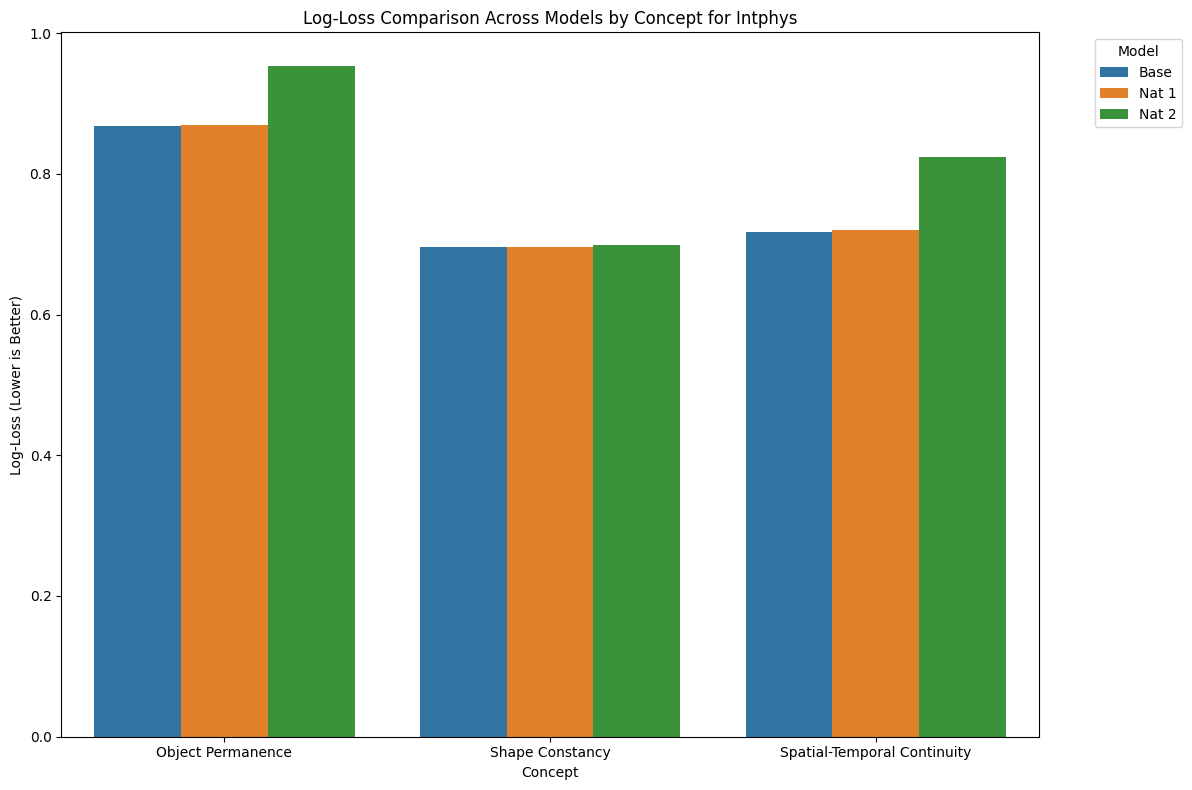

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss

# Helper function to prepare binary data and calculate log-loss
def prepare_binary_data(filepaths):
    # Concept labels corresponding to filepaths
    concept_labels = ['Object Permanence', 'Shape Constancy', 'Spatial-Temporal Continuity']
    trial_labels = ['Base', 'Nat 1', 'Nat 2']
    
    all_scores = []  # List to store DataFrames
    
    # Flatten the list of filepaths before processing
    filepaths = [filepath for sublist in filepaths for filepath in sublist]  # Flatten list of lists
    
    # Load and process each file (3 files per concept)
    for i, concept_label in enumerate(concept_labels):
        for j, path in enumerate(filepaths[i*3:(i+1)*3]):  # Get three files per concept
            df = pd.read_csv(path)
            
            # Convert label column to integer (True = 1, False = 0)
            df['label'] = df['label'].astype(int)
            
            # Add Concept and Trial labels
            df['Concept'] = concept_label
            df['Trial'] = trial_labels[j]
            
            # Compute Log Loss using sklearn's log_loss function
            y_true = df['label']  # True labels (1/0)
            y_pred = df['yes_prob']  # Predicted probabilities (for 'Yes')
            
            # Calculate log-loss for this trial's data
            log_loss_value = log_loss(y_true, y_pred)
            all_scores.append({
                'Concept': concept_label,
                'Trial': trial_labels[j],
                'Log Loss': log_loss_value
            })

    return pd.DataFrame(all_scores)

# Main function to plot the log-loss comparison
def plot_log_loss_comparison(all_scores):
    # Create the plot
    plt.figure(figsize=(12, 8))

    # Create the plot (side-by-side bars for each Concept)
    sns.barplot(data=all_scores, x='Concept', y='Log Loss', hue='Trial')

    # Adjust plot labels and title
    plt.title("Log-Loss Comparison Across Models by Concept for Intphys")
    plt.ylabel("Log-Loss (Lower is Better)")
    plt.xlabel("Concept")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside

    plt.tight_layout()  # Ensure everything fits
    plt.show()

# 🔽 Sample usage:
object_permanence_csvs = ['resp_intphys_O1_continuous_base.csv', 'resp_intphys_O1_continuous_nat.csv', 'resp_intphys_O1_continuous_nat-2000.csv']
shape_constancy_csvs = ['resp_intphys_O2_continuous_og.csv', 'resp_intphys_O2_nat_og-continuous.csv', 'resp_intphys_O2_nat-2000-continous.csv']
spatial_temporal_continuity_csvs = ['resp_intphys_O3_continuous_base.csv', 'resp_intphys_O3_continuous_nat.csv', 'resp_intphys_O3_continuous_nat-2000.csv']

# Collect all the log loss data from each concept (3 CSVs per concept)
all_scores = prepare_binary_data([object_permanence_csvs, shape_constancy_csvs, spatial_temporal_continuity_csvs])

# Plotting the log-loss comparison
plot_log_loss_comparison(all_scores)

Concept: Object Permanance, Trial: Base
Accuracy Proportion: 0.50
Invalid Proportion: 0.50
------------------------------
Concept: Object Permanance, Trial: Nat 1
Accuracy Proportion: 0.50
Invalid Proportion: 0.50
------------------------------
Concept: Object Permanance, Trial: Nat 2
Accuracy Proportion: 0.45
Invalid Proportion: 0.55
------------------------------
Concept: Shape Consistency, Trial: Base
Accuracy Proportion: 0.00
Invalid Proportion: 1.00
------------------------------
Concept: Shape Consistency, Trial: Nat 1
Accuracy Proportion: 0.02
Invalid Proportion: 0.98
------------------------------
Concept: Shape Consistency, Trial: Nat 2
Accuracy Proportion: 0.33
Invalid Proportion: 0.67
------------------------------
Concept: Spatial Temporal Continuity, Trial: Base
Accuracy Proportion: 0.50
Invalid Proportion: 0.50
------------------------------
Concept: Spatial Temporal Continuity, Trial: Nat 1
Accuracy Proportion: 0.50
Invalid Proportion: 0.50
------------------------------

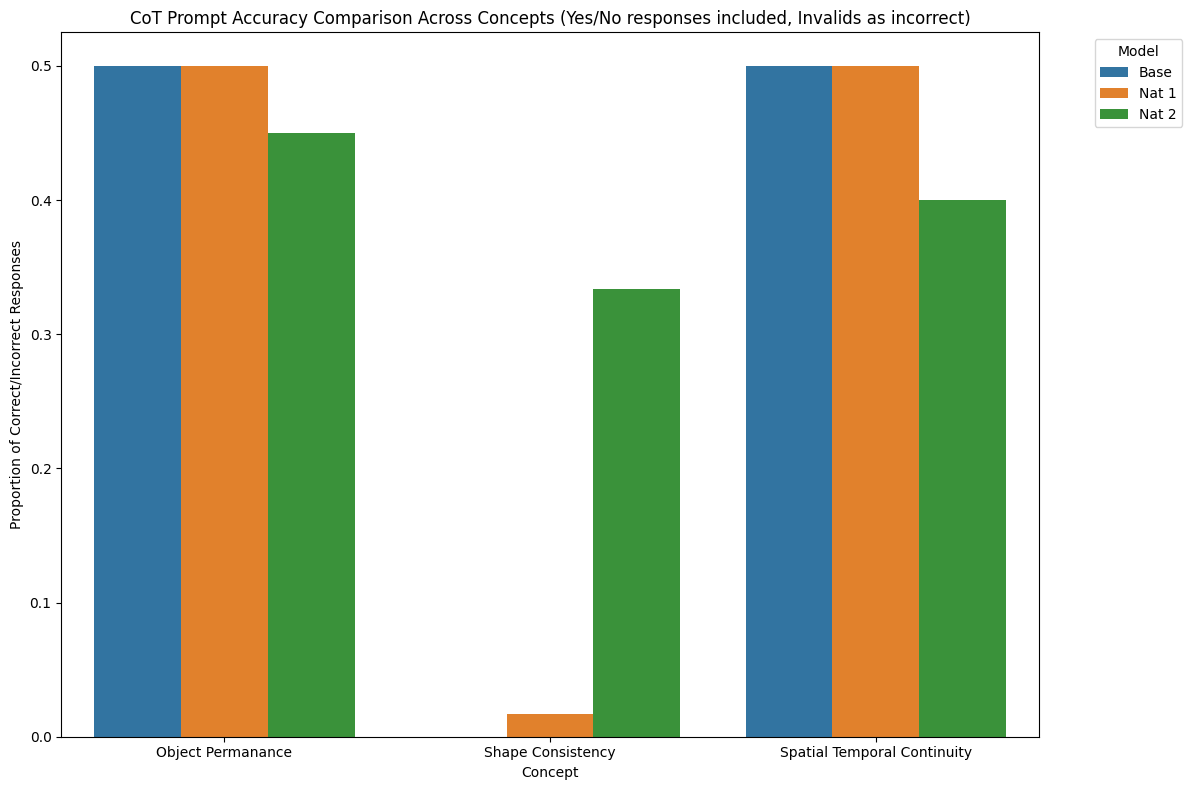

Concept: Object Permanance, Trial: Nat 2
Invalid Proportion (of incorrect responses): 0.09
------------------------------
Concept: Shape Consistency, Trial: Base
Invalid Proportion (of incorrect responses): 1.00
------------------------------
Concept: Shape Consistency, Trial: Nat 2
Invalid Proportion (of incorrect responses): 0.32
------------------------------
Concept: Spatial Temporal Continuity, Trial: Nat 2
Invalid Proportion (of incorrect responses): 0.20
------------------------------


/tmp/ipykernel_2620523/3475980604.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (concept, trial), group in invalid_data.groupby(['Concept', 'Trial']):


<Figure size 1200x800 with 0 Axes>

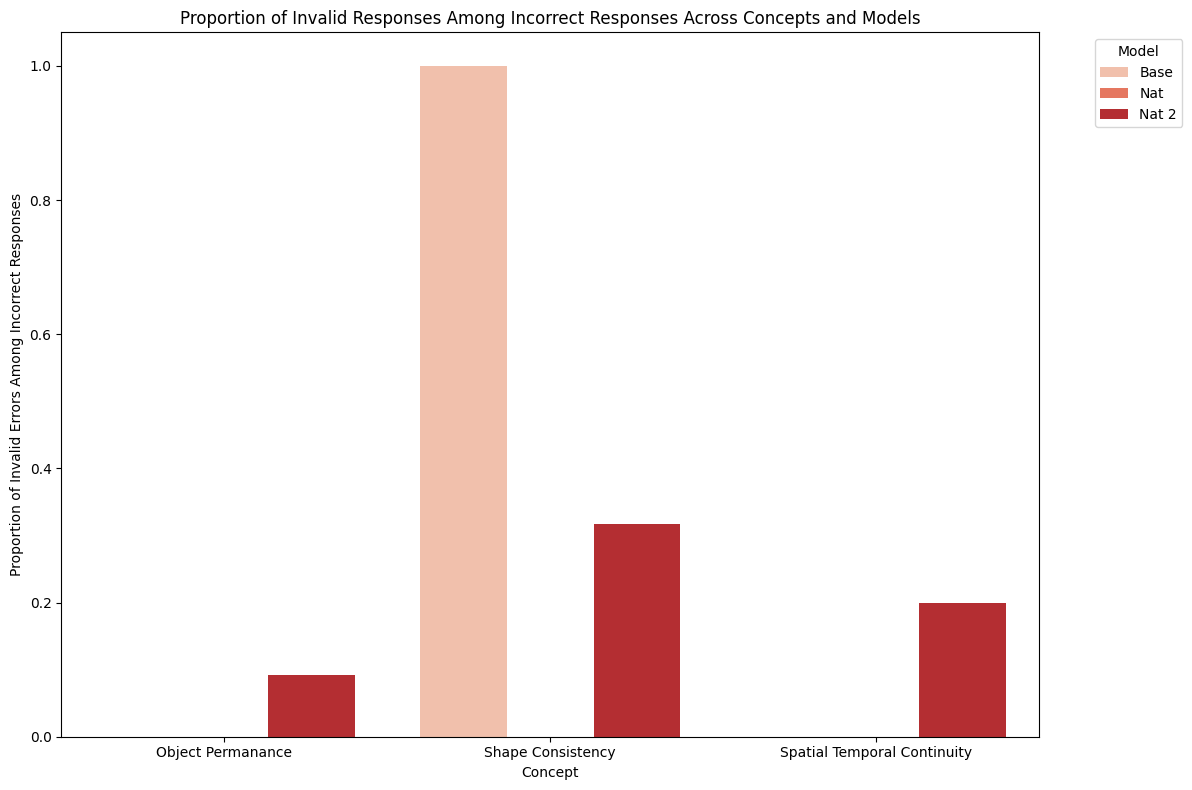

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to prepare binary data and calculate accuracy for each model
def prepare_binary_data_with_invalid(filepaths):
    # Concept labels corresponding to filepaths
    concept_labels = ['Object Permanance', 'Shape Consistency', 'Spatial Temporal Continuity']
    trial_labels = ['Base', 'Nat 1', 'Nat 2']
    
    all_scores = []  # List to store DataFrames
    invalid_counts = 0  # Count of invalid responses (neither 'Yes' nor 'No')
    total_responses = 0  # Total number of responses
    incorrect_due_to_mismatch = 0  # Count of incorrect responses due to 'Yes'/'No' mismatch
    
    # Flatten the list of filepaths before processing
    filepaths = [filepath for sublist in filepaths for filepath in sublist]  # Flatten list of lists
    
    # Load and process each file
    for i, concept_label in enumerate(concept_labels):
        for j, path in enumerate(filepaths[i*3:(i+1)*3]):  # 3 models per concept
            df = pd.read_csv(path)
            
            # Add Concept and Trial labels
            df['Concept'] = concept_label
            df['Trial'] = trial_labels[j]
            
            # Initialize accuracy and invalid response count
            df['accuracy'] = None
            df['invalid'] = False
            df['incorrect_due_to_mismatch'] = False
            
            for index, row in df.iterrows():
                total_responses += 1
                response = row['response'].strip()
                
                # If response is not 'Yes' or 'No', mark as incorrect and invalid
                if response not in ['Yes', 'No']:
                    df.at[index, 'accuracy'] = False
                    df.at[index, 'invalid'] = True
                    invalid_counts += 1
                else:
                    # Compare 'response' to 'label' (True = correct, False = incorrect)
                    if response == 'Yes' and row['label'] == False:
                        df.at[index, 'accuracy'] = False
                        df.at[index, 'incorrect_due_to_mismatch'] = True
                        incorrect_due_to_mismatch += 1
                    elif response == 'No' and row['label'] == True:
                        df.at[index, 'accuracy'] = False
                        df.at[index, 'incorrect_due_to_mismatch'] = True
                        incorrect_due_to_mismatch += 1
                    else:
                        df.at[index, 'accuracy'] = True
            
            all_scores.append(df)
    
    # Concatenate all DataFrames and calculate the percentage of invalid responses
    all_scores_df = pd.concat(all_scores, ignore_index=True)
    invalid_percentage = (invalid_counts / total_responses) * 100
    incorrect_percentage_due_to_mismatch = (incorrect_due_to_mismatch / total_responses) * 100
    
    return all_scores_df, invalid_counts, total_responses

# Main function to plot the accuracy comparison
def plot_accuracy_comparison_with_invalid(all_scores, invalid_counts, total_responses):
    # Create the plot for accuracy (Yes/No responses only)
    plt.figure(figsize=(12, 8))

    # Compute proportions of correct/incorrect for each Concept and Trial, including 'Yes'/'No' responses and invalids
    accuracy_data = all_scores.groupby(['Concept', 'Trial', 'accuracy']).size().reset_index(name='count')
    
    # Calculate the total count for each (Concept, Trial)
    total_counts = accuracy_data.groupby(['Concept', 'Trial'])['count'].transform('sum')
    
    # Calculate the proportion of correct (accuracy=True) vs incorrect (accuracy=False) including invalid
    accuracy_data['proportion'] = accuracy_data['count'] / total_counts
    accuracy_proportion_data = accuracy_data[accuracy_data['accuracy'] == True]
    for (concept, trial), group in accuracy_data.groupby(['Concept', 'Trial']):
        # Calculate the accuracy or invalid percentage
        accuracy_proportion = group[group['accuracy'] == True]['proportion'].sum()
        invalid_proportion = group[group['accuracy'] == False]['proportion'].sum()
        
        print(f"Concept: {concept}, Trial: {trial}")
        print(f"Accuracy Proportion: {accuracy_proportion:.2f}")
        print(f"Invalid Proportion: {invalid_proportion:.2f}")
        print("-" * 30)  # Separator for readability
    # Create the plot (side-by-side bars for each Concept)
    sns.barplot(data=accuracy_proportion_data, x='Concept', y='proportion', hue='Trial')

    # Adjust plot labels and title
    plt.title("CoT Prompt Accuracy Comparison Across Concepts (Yes/No responses included, Invalids as incorrect)")
    plt.ylabel("Proportion of Correct/Incorrect Responses")
    plt.xlabel("Concept")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside

    plt.tight_layout()  # Ensure everything fits
    plt.show()

    # Plot for the invalid response percentage
    plt.figure(figsize=(12, 8))

    # Create bars for invalid and incorrect response percentages for each Concept and Trial
    invalid_counts_data = all_scores.groupby(['Concept', 'Trial', 'invalid']).size().reset_index(name='count')
    incorrect_counts_data = all_scores.groupby(['Concept', 'Trial', 'incorrect_due_to_mismatch']).size().reset_index(name='count')
    
    # Calculate total responses for each Concept and Trial
    total_counts_invalid = invalid_counts_data.groupby(['Concept', 'Trial'])['count'].transform('sum')
    invalid_counts_data['proportion'] = invalid_counts_data['count'] / total_counts_invalid

    total_counts_incorrect = incorrect_counts_data.groupby(['Concept', 'Trial'])['count'].transform('sum')
    incorrect_counts_data['proportion'] = incorrect_counts_data['count'] / total_counts_incorrect
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Compute the total counts of invalid responses per Concept and Trial
    invalid_data = all_scores.groupby(['Concept', 'Trial', 'invalid', 'accuracy']).size().reset_index(name='count')

    # Calculate total incorrect responses (accuracy=False) for each Concept and Trial
    incorrect_data = invalid_data[invalid_data['accuracy'] == False]

    # Now calculate the total incorrect count for each Concept and Trial
    total_incorrect_counts = incorrect_data.groupby(['Concept', 'Trial'])['count'].transform('sum')

    # Add the total incorrect count to the invalid_data for easier calculation
    invalid_data['total_incorrect'] = invalid_data.groupby(['Concept', 'Trial'])['count'].transform('sum')

    # Filter for invalid responses only (invalid=True and accuracy=False)
    invalid_data = invalid_data[(invalid_data['invalid'] == True) & (invalid_data['accuracy'] == False)]

    # Calculate the proportion of invalid responses relative to the total incorrect responses
    invalid_data['proportion_invalid'] = invalid_data['count'] / invalid_data['total_incorrect']

    # Sort the data to ensure proper ordering in the plot (Trial and Concept)
    trial_order = ['Base', 'Nat', 'Nat 2']  # Order of the trials
    invalid_data['Trial'] = pd.Categorical(invalid_data['Trial'], categories=trial_order, ordered=True)
    invalid_data = invalid_data.sort_values(by=['Concept', 'Trial'])

    # Print the invalid proportions for verification
    for (concept, trial), group in invalid_data.groupby(['Concept', 'Trial']):
        invalid_proportion = group['proportion_invalid'].sum()
        print(f"Concept: {concept}, Trial: {trial}")
        print(f"Invalid Proportion (of incorrect responses): {invalid_proportion:.2f}")
        print("-" * 30)  # Separator for readability

    # Create the barplot showing the proportion of invalid responses out of incorrect responses
    sns.barplot(data=invalid_data, x='Concept', y='proportion_invalid', hue='Trial', palette="Reds")

    # Title and labels
    plt.title("Proportion of Invalid Responses Among Incorrect Responses Across Concepts and Models")
    plt.ylabel("Proportion of Invalid Errors Among Incorrect Responses")
    plt.xlabel("Concept")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside

    plt.tight_layout()  # Ensure everything fits
    plt.show()
# 🔽 Sample usage:
# Example CSV files
concept_1_csvs = ['resp_intphys_O1_COT_base.csv', 'resp_intphys_O1_COT_nat.csv', 'resp_intphys_O1_COT_nat-2000.csv']  # Replace with actual paths
concept_2_csvs = ['resp_intphys_O2_COT_base.csv', 'resp_intphys_O2_COT_nat.csv', 'resp_intphys_O2_COT_nat-2000.csv']  # Replace with actual paths
concept_3_csvs = ['resp_intphys_O3_COT_base.csv', 'resp_intphys_O3_COT_nat.csv', 'resp_intphys_O3_COT_nat-2000.csv']  # Replace with actual paths

# Collect all the binary data from the concepts (3 CSVs per concept)
all_scores, invalid_percentage, incorrect_percentage_due_to_mismatch = prepare_binary_data_with_invalid([concept_1_csvs, concept_2_csvs, concept_3_csvs])

# Plotting the accuracy comparison and invalid response percentage
plot_accuracy_comparison_with_invalid(all_scores, invalid_percentage, incorrect_percentage_due_to_mismatch)
